In [35]:
# First import stuff
import pandas as pd
import math
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
import pylab
import sklearn as sk
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras as kr
from keras.models import Sequential
from keras.layers import InputLayer, Input
from keras.layers import Reshape, MaxPooling2D
from keras.layers import Conv2D, Dense, Flatten, Dropout
from keras import optimizers
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
import seaborn as sns
from livelossplot import PlotLossesKeras
from sklearn.metrics import accuracy_score


print('Using matplotlib version', matplotlib.__version__)
print('Using sklearn version', sk.__version__)
print('Using tensorflow version', tf.__version__)
print('Using keras version', kr.__version__)

import socket
my_hostname=socket.gethostbyaddr(socket.gethostname())[0]
print('You are running on ', my_hostname)


Using matplotlib version 3.3.2
Using sklearn version 0.23.2
Using tensorflow version 2.3.0
Using keras version 2.4.3
You are running on  wudangshan


In [36]:
import os
import uproot
from root_pandas import read_root


data_tth=None
data_ttv=None
data_tt=None

useRootInput=True

if useRootInput: # the default
    # Use uproot
    idir = '{}inputs/2016_legacy_skim_v1'.format('/nfs/user/pvischia/tth/dnn/' if 'cism.ucl.be' in my_hostname else './')

    file_tth = "{}/TTHnobb_fxfx_Friend.root".format(idir)
    key = "Friends"
    data_tth_orig = read_root(file_tth, key)

    
    
    
    #tth_dnn_tree = uproot.open(file_tth)[key]
    #print("Number of jets: ", tth_dnn_tree['Hreco_nJets'].array()[0])
    #print("jets pT: ", tth_dnn_tree['Hreco_Jet_pt'].array()[0])
    #print("jets Eta: ", tth_dnn_tree['Hreco_Jet_eta'].array()[0])
    #print("lep1 pT: ", tth_dnn_tree['Hreco_Lep1_pt'].array()[0])
    #data_tth = tth_dnn_tree.arrays(outputtype=pd.DataFrame)
    ##data_tth = tth_dnn_tree.pandas.df(flatten=False)
    


In [37]:
# Visualize the first few lines
#print(len(data_tth))

data_tth=data_tth_orig # save the original
test=data_tth['Hreco_Jet_pt']
l = [len(i) for i in test]
maxl = max(l)

for lab in ['pt', 'eta', 'phi', 'mass', 'isbtagged', 'ishadtop']:
    label='Hreco_Jet_%s'%lab
    tempLab=data_tth[label]
    data_tth.drop([label], axis=1, inplace=True)
    out = pd.DataFrame(tempLab.tolist(),columns=[ 'Hreco_Jet%s_%s'%(i, lab) for i in range(maxl)])
    data_tth = pd.concat([data_tth, out], axis=1)

#print(data_tth['Hreco_Jet_pt'])
data_tth_nans=data_tth
# DeNaN it
data_tth.fillna(0, inplace=True)

#temp = pd.DataFrame(data_tth['Hreco_Jet_pt'])
#temp_expanded=pd.DataFrame(temp.values.tolist())

#temp_expanded.head()
#cols={}
#for i in range(max(l)):
#    cols[0] = 'Hreco_Jet%s_pt'%i
#temp_expanded.rename(columns=cols,inplace=True)
#print(temp_expanded)


In [38]:
# There's no third lepton, jet mass not filled, 7 jets not stored
# HadTop (and the score) would be redundant if using the individual jets
# evt_tag is the leptonic flavour of the event, for later splitting. Must put it into a spectator variable
thevars = [
# Hreco_nLeps
'Hreco_nJets',
'Hreco_Lep0_pt','Hreco_Lep0_eta','Hreco_Lep0_phi', #'Hreco_Lep0_mass',
'Hreco_Lep1_pt','Hreco_Lep1_eta','Hreco_Lep1_phi', #'Hreco_Lep1_mass',
'Hreco_HadTop_pt','Hreco_HadTop_eta','Hreco_Lep1_phi','Hreco_HadTop_phi','Hreco_HadTop_mass',
'Hreco_TopScore',
'Hreco_met','Hreco_met_phi',
'Hreco_DeltaRClosestJetToLep0',
'Hreco_DeltaPtClosestJetToLep0',
'Hreco_DeltaRClosestJetToLep1',
'Hreco_DeltaPtClosestJetToLep1',
'Hreco_DeltaRl0l1',
]

for i in range(16):
    thevars.append('Hreco_Jet%s_pt'%i)
    thevars.append('Hreco_Jet%s_eta'%i)
    thevars.append('Hreco_Jet%s_phi'%i)
    thevars.append('Hreco_Jet%s_mass'%i)
    thevars.append('Hreco_Jet%s_isbtagged'%i)
    thevars.append('Hreco_Jet%s_ishadtop'%i)
                


useAllDeltaRs=False
# We should add for each lepton a variable that is the pt of the closest jet and probably labelled in a way that identifies the jet
if useAllDeltaRs and ('deltars' in idir or 'drll' in idir):
    for j in range(6):
        for l in range(2):
            thevars.append('DeltaRl%sj%s'%(l,j))
    
        for jo in range(j,6):
            if j!= jo:
                thevars.append('DeltaRj%sj%s'%(j,jo))

# This can be added anyway
thevars.append('Hreco_DeltaRl0l1')

spect = [ 'Hreco_met', 'Hreco_evt_tag']
thetarget = ['HTXS_Higgs_pt','HTXS_Higgs_y', 'Hgen_vis_pt', 'Hgen_tru_pt'] # Hgen_tru_pt is the same as HTXS_Higgs_pt

addPrefix=True
if addPrefix:
    #thevars = [ 'Hreco_%s'%i for i in thevars]
    thetarget = [ 'Hreco_%s'%i for i in thetarget]
    #spect = [ 'Hreco_%s'%i for i in spect]

print('TRAINING FEATURES')
print(thevars)

TRAINING FEATURES
['Hreco_nJets', 'Hreco_Lep0_pt', 'Hreco_Lep0_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_pt', 'Hreco_Lep1_eta', 'Hreco_Lep1_phi', 'Hreco_HadTop_pt', 'Hreco_HadTop_eta', 'Hreco_Lep1_phi', 'Hreco_HadTop_phi', 'Hreco_HadTop_mass', 'Hreco_TopScore', 'Hreco_met', 'Hreco_met_phi', 'Hreco_DeltaRClosestJetToLep0', 'Hreco_DeltaPtClosestJetToLep0', 'Hreco_DeltaRClosestJetToLep1', 'Hreco_DeltaPtClosestJetToLep1', 'Hreco_DeltaRl0l1', 'Hreco_Jet0_pt', 'Hreco_Jet0_eta', 'Hreco_Jet0_phi', 'Hreco_Jet0_mass', 'Hreco_Jet0_isbtagged', 'Hreco_Jet0_ishadtop', 'Hreco_Jet1_pt', 'Hreco_Jet1_eta', 'Hreco_Jet1_phi', 'Hreco_Jet1_mass', 'Hreco_Jet1_isbtagged', 'Hreco_Jet1_ishadtop', 'Hreco_Jet2_pt', 'Hreco_Jet2_eta', 'Hreco_Jet2_phi', 'Hreco_Jet2_mass', 'Hreco_Jet2_isbtagged', 'Hreco_Jet2_ishadtop', 'Hreco_Jet3_pt', 'Hreco_Jet3_eta', 'Hreco_Jet3_phi', 'Hreco_Jet3_mass', 'Hreco_Jet3_isbtagged', 'Hreco_Jet3_ishadtop', 'Hreco_Jet4_pt', 'Hreco_Jet4_eta', 'Hreco_Jet4_phi', 'Hreco_Jet4_mass', 'Hreco_Jet4_isbt

In [39]:
# Set the target variable (0: pt, 1: rapidity), in case of 1D output
target = [thetarget[0]]

# Take the logarithm to compress range (for the pt)?
#data_tth[target] = np.log(data_tth[target])
# or 
#if 'pt' in target[0]:
#data_tth[target] = data_tth[target].apply(lambda x : np.log(x))
#for var in thevars+spect+target:
#    if 'pt' and 'Jet' in var:
#        data_tth[var] = data_tth[var].apply(lambda x : np.log(x))

# Save non-preprocessed data for later
data_orig_tth = data_tth

In [53]:
x_train, x_test, y_train, y_test = train_test_split(data_tth[thevars], data_tth[target], random_state=7)

In [41]:
# The model

def my_model(lr=5e-2):
    model = Sequential()
    model.add(Dense(3*len(thevars), input_dim=len(thevars), kernel_initializer='glorot_normal'))#TruncatedNormal'))
    #model.add(Dropout(0.2, input_shape=(len(thevars),))) # 20% dropout for input features
    for Nnodes in [3*len(thevars),2*len(thevars),len(thevars),int(len(thevars)/2)]:
        model.add(BatchNormalization())
        model.add(Dense(Nnodes, kernel_initializer='glorot_normal'))
        #model.add(PReLU())
        model.add(Activation('elu'))
        #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='he_normal'))
    model.add(Activation('elu'))
    
    adam = optimizers.Adam(lr=lr,amsgrad=True) 
    #model.compile(loss='mean_absolute_percentage_error', optimizer=adam, metrics=['mse'])
    #model.compile(loss='mean_absolute_error', optimizer=adam)
    #model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    model.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['mse']) # logerror good if target range is vast
    #model.compile(loss='mean_absolute_error', optimizer=adam, metrics=['mse']) # logerror good if target range is vast
    return model

preprocess=False
def my_training(lr,epochs=20):
    my_regression = KerasRegressor(
        build_fn=my_model, 
        epochs=epochs, 
        batch_size=256, 
        verbose=2,
        lr=lr
)
    cb_list = [PlotLossesKeras()]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,min_delta=0.0001)
    earlyStopping=False
    if earlyStopping:
        cb_list.append(es)
    history = my_regression.fit(
        x_train if not preprocess else x_train_scaled, 
        y_train,
        validation_data=(
            x_test if not preprocess else x_test_scaled, 
            y_test
        ),
        callbacks=cb_list
    )
    return my_regression, history

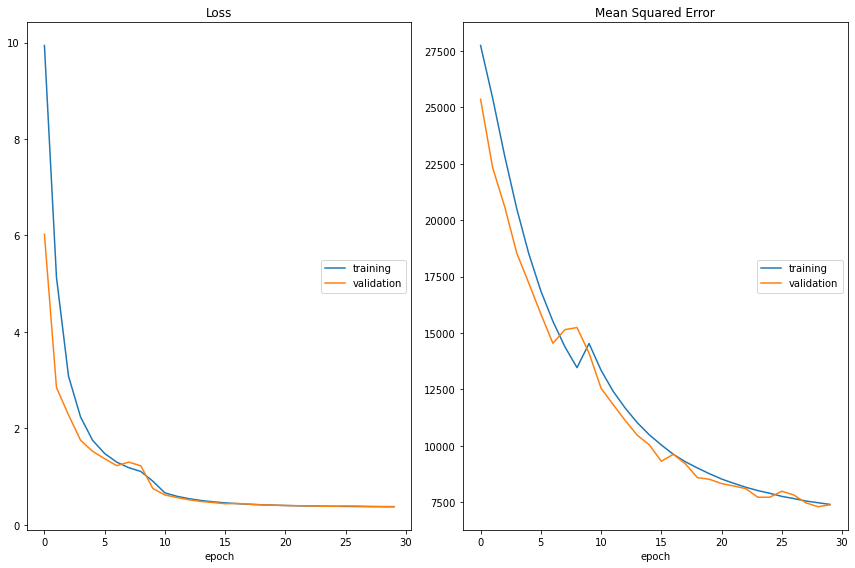

Loss
	training         	 (min:    0.376, max:    9.940, cur:    0.376)
	validation       	 (min:    0.379, max:    6.025, cur:    0.380)
Mean Squared Error
	training         	 (min: 7404.265, max: 27738.912, cur: 7404.265)
	validation       	 (min: 7301.709, max: 25355.639, cur: 7388.048)
259/259 - 3s - loss: 0.3764 - mse: 7404.2651 - val_loss: 0.3797 - val_mse: 7388.0483


In [42]:
model, hist= my_training(1e-3,epochs=30)
plt.show()



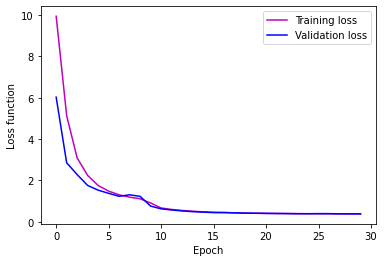

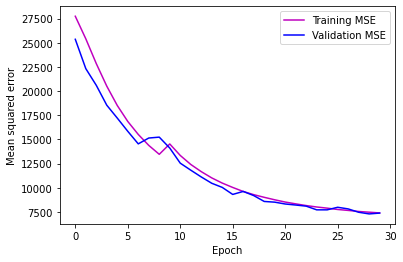

In [43]:
plt.plot(hist.history['loss'],color='m',label='Training loss')
plt.plot(hist.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
plt.show()
plt.plot(hist.history['mse'], color='m', label='Training MSE')
plt.plot(hist.history['val_mse'], color='b', label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.legend(loc='upper right')
plt.show()

import eli5
from eli5.sklearn import PermutationImportance
doperm=False
if doperm:
    showvarimp=pd.DataFrame(x_train if not preprocess else x_train_scaled,columns=data_tth[thevars].columns)
    perm = PermutationImportance(model, random_state=1).fit(showvarimp,y_train)
    eli5.show_weights(perm, feature_names = showvarimp.columns.tolist())



87/87 - 0s


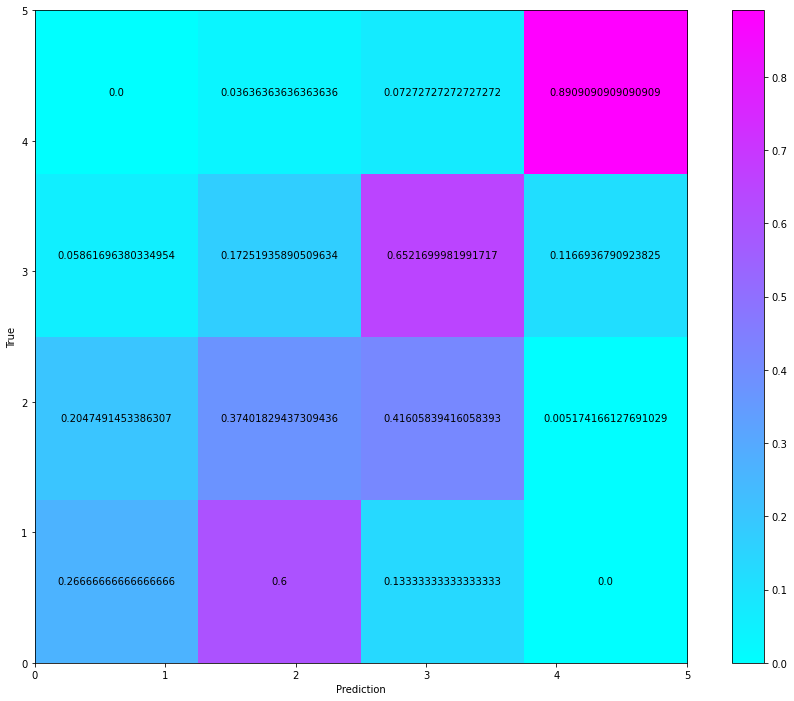

In [54]:
pred = model.predict(x_test)


def catfrompt(pt):
    if pt<50:
        return 0
    if pt<100:
        return 1
    if pt<300:
        return 2
    return 3


# Categorical target

ytest=y_test
ytest['Hreco_HTXS_Higgs_pt']= ytest['Hreco_HTXS_Higgs_pt'].apply(lambda x: catfrompt(x))


predicted=[ catfrompt(i) for i in pred]

#for i, j in zip(predicted, pred):
#    print(i, j)
#for i in range(4):
#     print("There are %s occurrences of ytrue==%s"%(np.count_nonzero(ytest == i), i))
        
        
#for i in range(4):
#     print("There are %s occurrences of ypredicted==%s"%(np.count_nonzero(predicted == i), i))

response, _, _ = np.histogram2d(predicted, ytest['Hreco_HTXS_Higgs_pt'], bins=[np.linspace(0,4,5),np.linspace(0,4,5)])                                                                                                                                                                                                                                   
sum_of_rows = response.sum(axis=1)
norm_response = response / sum_of_rows[:, np.newaxis]

fig = plt.figure(figsize=(16, 12))
ax2 = fig.add_subplot(111)
size=4
x_start = 0.0
x_end = 5.0
y_start = 0.0
y_end = 5.0
extent = [x_start, x_end, y_start, y_end]
im=ax2.imshow(norm_response,extent=extent,origin="lower",interpolation='None',cmap="cool")
ax2.set_xlabel("Prediction")
ax2.set_ylabel("True")


# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = norm_response[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax2.text(text_x, text_y, label, color='black', ha='center', va='center')

fig.colorbar(im)
plt.show()


In [ ]:
# Now plot true pt vs predicted pt

import seaborn as sns

viz_x_test = x_test if not preprocess else x_test_scaled
viz_x_test=pd.DataFrame(viz_x_test,columns=data_tth[thevars].columns)
prediction = model.predict(viz_x_test.values)
lincorr = np.corrcoef(prediction, np.transpose(y_test))
print('SHAPES', prediction.shape, np.transpose(y_test).shape)
#vexp = np.vectorize(math.exp)
#blah = plt.scatter(vexp(y_test[target].values),vexp(prediction),s=0.01)
blah = plt.scatter(y_test[target].values,prediction,s=0.01)


plt.xlabel('True %s'%target[0])
plt.ylabel('Predicted %s'%target[0])
myxlim = plt.xlim()
myylim = plt.ylim()
lowcoord = min(myxlim[0],myylim[0]) if 'HTXS_Higgs_pt' not in target else 0
higcoord = max(myxlim[1],myylim[1])
_ = plt.plot([lowcoord,higcoord],[lowcoord,higcoord], c='red',ls='--')
plt.text((higcoord-lowcoord)*0.1,(higcoord-lowcoord)*0.7,'Lin corr = %.3f'%(lincorr[0,1]))
plt.show()


# Now plot the relative error between the predicted pt and true pt
diff = prediction-y_test[target].values.reshape(-1)
plt.hist(diff/y_test[target].values.reshape(-1),log=True,bins=1000)
plt.xlabel('Relative error (prediction-true)/true')
plt.show()
lincorrbacktopt=None


#plt.hist(vexp(prediction),alpha=0.5,log=False,bins=1000,label='Prediction')
#plt.hist(vexp(y_test[target].values),alpha=0.5,log=False,bins=1000,label='True pt')
#print('The SHAPES', prediction.shape, y_test[target].values.shape)
np.reshape(prediction,(prediction.shape[0],1))
plt.hist(prediction,alpha=0.5,log=False,bins=1000,label='Prediction')
plt.hist(y_test[target].values,alpha=0.5,log=False,bins=1000,label='True pt')
plt.legend(loc='upper right')
plt.show()
plt.scatter(y_test.values,diff/y_test[target].values.reshape(-1))
#plt.scatter(y_test[target].values,diff)
plt.xlabel('True %s'%target[0])
plt.ylabel('Standardadized residual w.r.t. true')
plt.show()
plt.scatter(y_test[target].values,diff/prediction.reshape(-1))
plt.ylim(-10,10)
#plt.scatter(prediction,diff)
plt.xlabel('Predicted %s'%target[0])
plt.ylabel('Standardadized residual w.r.t. predicted')
plt.show()
nxbins=10
ax = sns.regplot(y_test[target].values,diff/y_test[target].values.reshape(-1),x_bins=nxbins)
ax.set(xlabel='True %s (%s bins)'%(target,nxbins), ylabel='(prediction-true)/true')
plt.show()
if bkgs:
    ttv_prediction = model.predict(data_ttv[thevars].values)
    tt_prediction = model.predict(data_tt[thevars].values)
    ttv_manip = ttv_prediction
    tt_manip = tt_prediction
    plt.hist(prediction,alpha=0.5,density=True,log=True,bins=500,label='TTH Prediction')
    plt.hist(ttv_manip,alpha=0.5,density=True,log=True,bins=500,label='TTV Prediction')
    plt.hist(tt_manip,alpha=0.5,density=True,log=True,bins=500,label='TT Prediction')
    plt.legend(loc='upper right')
    plt.show()
print('Shape of prediction:', prediction.shape)
print('Shape of valdataset met:', viz_x_test[['met']].shape)
print('Shape of valdataset met values:', viz_x_test[['met']].values.shape)
print('Linear correlation:', lincorr)
print('Linear correlation (back to pt):', lincorrbacktopt)